## Importing libraries

In [44]:
import pandas as pd
import numpy as np
import random
import sqlite3
#metrics and evaluation
from metrics_and_evaluation import zero_rule_algorithm_classification, recall_m, f1_m, precision_m, assign_pred, plot_cm
from sklearn.metrics import cohen_kappa_score, confusion_matrix
#preprocessing
from sklearn import preprocessing
#encoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical
#tokenization
from keras.preprocessing.text import Tokenizer
#modeling
from keras import models
from keras import layers
from keras.layers import Lambda, Dense, Dropout
from keras.callbacks import  EarlyStopping
# to save model
import pickle
from keras.models import Sequential, model_from_json

## Import Data

In [45]:
#database connection
conn = sqlite3.connect( r"./data/emotion.db")
c = conn.cursor()

In [46]:
#importing preprocessed data to a dataframe
twitter_df = pd.read_sql_query("""SELECT text, clean_text, emotion
                                  FROM emotions_preprocessed_sample
                                  ORDER BY clean_text ASC;""", conn)

In [47]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300252 entries, 0 to 300251
Data columns (total 3 columns):
text          300252 non-null object
clean_text    300252 non-null object
emotion       300252 non-null object
dtypes: object(3)
memory usage: 6.9+ MB


In [48]:
twitter_df.shape

(300252, 3)

In [49]:
twitter_df.head()

,text,clean_text,emotion
0,--_-- *_* +_-- Oh No!! Just when I start celebrating..thinking he's outta my hair...He shoots me a text!! --_+ #Annoyed,_ _ _ oh no just when i start celebrating thinking he is outta my hair he shoot me a text _,anger
1,"(`-`) (._. ) (· - ·) ( ._.) ( ' -') cnt sleep,, keep hearin paranormal activity n my room... #Nervous",_ _ cnt sleep keep hearin paranormal activity n my room,fear
2,#SomethingUnusualOnThanksGiving _ a grillled turkey.. I'm really nervous for this /:| #uneasiness,_ a grilled turkey i am really nervous for this,fear
3,-_- dudes that swear they the king of rap but his only supporter/number1 Fan is his mom. #sad,_ dude that swear they the king of rap but his only supporter number fan is his mom,sadness
4,-_- fcuk I guess I'm not done xmas shopping. #ANNOYING!,_ fcuk i guess i am not done xmas shopping,anger


__Calculating Baseline Accuracy using Zero Rule Algorithm__

Reference: https://machinelearningmastery.com/implement-baseline-machine-learning-algorithms-scratch-python/

In [107]:
data = twitter_df[['clean_text','emotion']]
data['pred'] = None

In [117]:
#70% of dataset
training_set = data.emotion.apply(lambda x: [x])[:210177].tolist()

In [118]:
#30% of dataset
testing_set = data.pred.apply(lambda x: [x])[210177:].tolist()

In [119]:
predictions = zero_rule_algorithm_classification(training_set, testing_set)
print(predictions)

['joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy'

210177

In [120]:
testing_set.value_counts()

[joy]        59324
[sadness]    54273
[anger]      52484
[fear]       44096
Name: emotion, dtype: int64

The baseline model predicted all values to be classifed as joy. 

__Accuracy score for baseline:__
(59324/210177)*100 = 28.23%

## tokenization & encoding

In [50]:
num_words = 10000
comments = twitter_df['clean_text']
tokenizer = Tokenizer(num_words = num_words+1)
tokenizer.fit_on_texts(comments)
sequences = tokenizer.texts_to_sequences(comments)
print('sequences type:', type(sequences))

sequences type: <class 'list'>


In [51]:
x = tokenizer.texts_to_matrix(comments, mode='binary')
print('x type:', type(x))

x type: <class 'numpy.ndarray'>


In [52]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 67427 unique tokens.


In [53]:
reverse_index = dict([(value, key) for (key, value) in word_index.items()])
comment_idx_to_preview = 318
print('Original text:')
print(comments[comment_idx_to_preview])

Original text:
a everyone else on floor apart from me ha gone out tonight lack of fund i am going to curl up and watch the grinch


In [54]:
decoded_review = ' '.join([reverse_index.get(i) for i in sequences[comment_idx_to_preview]])
print('Decoded review from Tokenizer:')
print(decoded_review)

Decoded review from Tokenizer:
a everyone else on floor apart from me ha gone out tonight lack of fund i am going to curl up and watch the grinch


In [55]:
#Encoding target values
target = twitter_df['emotion']
le = preprocessing.LabelEncoder() #Initialize. le used as abbreviation fo label encoder
le.fit(target)
print("Original class labels:")
print(list(le.classes_))
print(target.shape)

Original class labels:
['anger', 'fear', 'joy', 'sadness']
(300252,)


In [56]:
#to retrieve the original descriptive labels post production
target_cat = le.transform(target)
print('New target labels:')
print(target_cat)
print('shape')
print (len(target_cat))
print('Target labels; 4 binary columns, one for each of the categories.') #Each row will be all zeros except for the category for that observation.

New target labels:
[0 1 1 ... 2 2 1]
shape
300252
Target labels; 4 binary columns, one for each of the categories.


In [57]:
target_labels = to_categorical(target_cat)
print(target_labels)
print('\n')
print('Target labels shape:')
print(np.shape(target_labels))
len(x)*.3

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]]


Target labels shape:
(300252, 4)


90075.59999999999

## Splitting Train and Test Data

In [24]:
#Generate Test Data (30% test data)
random.seed(42)
test_index = random.sample(range(0,300252), 90075)

In [25]:
#test data set for predictors
test = x[test_index]

In [26]:
#train data set for predictors
train = np.delete(x, test_index, 0)

In [27]:
# test and train dataset for target

label_test = target_labels[test_index]
label_train = np.delete(target_labels, test_index, 0)
print("Test label shape:", np.shape(label_test))
print("Train label shape:", np.shape(label_train))
print("Test shape:", np.shape(test))
print("Train shape:", np.shape(train))

Test label shape: (90075, 4)
Train label shape: (210177, 4)
Test shape: (90075, 10001)
Train shape: (210177, 10001)


## Modeling and training

In [28]:
#Model
model = models.Sequential()
model.add(Dropout(.2))
model.add(layers.Dense(500, activation='relu', input_shape=(10000,)))
model.add(Dropout(.2))
model.add(layers.Dense(100, activation='relu'))
model.add(Dropout(.2))
model.add(layers.Dense(50, activation='relu'))
model.add(Dropout(.2))
model.add(layers.Dense(4, activation='softmax'))
model.compile(optimizer='RMSprop',
             loss='categorical_crossentropy',
             metrics=['accuracy', f1_m, precision_m, recall_m])
es_callback = (EarlyStopping(monitor='val_loss', patience=3))

In [29]:
#fit model with train data

results = model.fit(train,
                   label_train,
                   epochs=120,
                   batch_size=250,
                   validation_split=0.2,
                   callbacks = [es_callback])

W1119 04:14:59.536899 140497901381376 deprecation_wrapper.py:119] From /usr/local/envs/py3env/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 168141 samples, validate on 42036 samples
Epoch 1/120
168141/168141 [==============================] - 48s 285us/step - loss: 1.0766 - accuracy: 0.5447 - f1_m: 0.4407 - precision_m: 0.6705 - recall_m: 0.3339 - val_loss: 0.9326 - val_accuracy: 0.6241 - val_f1_m: 0.5554 - val_precision_m: 0.7334 - val_recall_m: 0.4500
Epoch 2/120
168141/168141 [==============================] - 47s 281us/step - loss: 0.9882 - accuracy: 0.5946 - f1_m: 0.5313 - precision_m: 0.7033 - recall_m: 0.4275 - val_loss: 0.9157 - val_accuracy: 0.6358 - val_f1_m: 0.5661 - val_precision_m: 0.7443 - val_recall_m: 0.4601
Epoch 3/120
168141/168141 [==============================] - 48s 286us/step - loss: 0.9477 - accuracy: 0.6165 - f1_m: 0.5667 - precision_m: 0.7125 - recall_m: 0.4709 - val_loss: 0.8992 - val_accuracy: 0.6429 - val_f1_m: 0.6030 - val_precision_m: 0.7229 - val_recall_m: 0.5192
Epoch 4/120
168141/168141 [==============================] - 60s 356us/step - loss: 0.9113 - accuracy: 0.6336 - f1_m: 0.5

## Evaluating the model

In [30]:
# generate metrics
loss, accuracy, f1_score, precision, recall = model.evaluate(test, label_test, verbose=0)

In [31]:
print(' Loss:',loss,'\n', 'Accuracy:',accuracy,'\n','F1 Score:', f1_score,'\n','Precision:', precision,'\n', 'Recall:', recall )

 Loss: 0.9327503652880994 
 Accuracy: 0.6299972534179688 
 F1 Score: 0.6164131760597229 
 Precision: 0.6836270689964294 
 Recall: 0.5628063082695007


In [32]:
#creating a dataframe with test and prediction results
label_pred = model.predict(test)
classes = list(le.inverse_transform([0, 1, 2, 3]))
pred = pd.DataFrame(label_pred, columns = ['anger', 'fear', 'joy', 'sadness'] )
test_text = twitter_df.iloc[test_index]
test_text.reset_index(inplace = True)
classification = pd.concat([test_text,pred] , axis = 1)
classification.drop(columns = 'index' , inplace = True)
classification['pred']=''
classification = classification[['text','clean_text','anger','fear','joy','sadness','emotion','pred']]

/usr/local/envs/py3env/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [3]:
#Assigining predicted label
classification = assign_pred(classification,'anger',['fear','joy','sadness'])
classification = assign_pred(classification,'fear',['anger','joy','sadness'])
classification = assign_pred(classification,'joy',['fear','anger','sadness'])
classification = assign_pred(classification,'sadness',['fear','joy','anger'])

In [59]:
pd.set_option('display.max_colwidth', -1)
classification.head(5)

,text,clean_text,anger,fear,joy,sadness,emotion,pred
0,At the hospital waiting 2 see child no.4! #nervous,at the hospital waiting see child no,0.014792,0.804515,0.118222,0.062471,fear,fear
1,@CodyDeBrock i feel like koehler isnt doin anything and neither is mrs schaefer!! #annoyed,i feel like koehler is not doing anything and neither is mr schaefer,0.481132,0.061589,0.069232,0.388048,anger,anger
2,If i see another girl wit that no bf no prob shirt . imma chew her TF ^ ! Im sick of that shit !I t's PLAYED TF OUT -___________- #Disgusted,if i see another girl wit that no bf no prob shirt imma chew her tf i am sick of that shit i t s played tf out __,0.942553,0.001655,0.005897,0.049895,anger,anger
3,I need someone to cuddle with right now #lonely #comeover @JuliaPersinger @Gracie_masters @fcastros43 @MeyerMackenzie,i need someone to cuddle with right now,0.025190,0.008856,0.016392,0.949562,sadness,sadness
4,I hate getting on Justin's twitter & it says @justinbieber does not follow me :( #Depressed,i hate getting on justin s twitter it say doe not follow me,0.275751,0.010001,0.027876,0.686372,sadness,sadness


In [61]:
#saving results for analysis
classification.to_csv('./data/classification.csv')

In [58]:
#retrieving results
# classification = pd.read_csv('./data/classification.csv' , index_col = 0, error_bad_lines  = False)


In [34]:
# Cohen Kappa Score
y1 = classification.emotion
y2 = classification.pred
cks = cohen_kappa_score(y1, y2, labels=classes, weights=None, sample_weight=None)

In [35]:
print('Cohen Kappa Score:',cks)

Cohen Kappa Score: 0.5026165561696742


In [37]:
classification.pred.value_counts()

anger      27004
joy        24822
sadness    24042
fear       14207
Name: pred, dtype: int64

In [38]:
classification.emotion.value_counts()

sadness    24108
anger      24040
joy        23876
fear       18051
Name: emotion, dtype: int64

In [41]:
# Creating the Confusion Matrix
y_test = classification.emotion
y_pred = classification.pred
cm = confusion_matrix(y_test, y_pred)

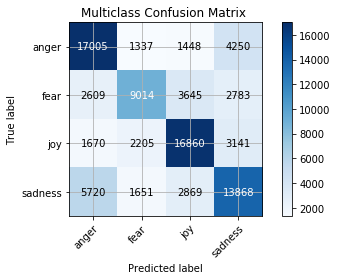

In [42]:
plot_cm(cm,classes)

Anger:
- labeled as anger = 24040
- correctly predicted as anger = 17005
- predicted as anger=  27004
- __anger posts labeled as sadness = 4250__
- anger posts labeled as fear = 1337
- anger posts labeled as joy = 1448


Fear:
- labeled as fear = 18051
- correctly predicted as fear = 9014
- predicted as fear = 14207
- fear posts labeled as anger = 2069
- __fear posts labeled as joy = 3645__
- fear posts labeled as sadness = 2783

Joy:

- labeled as joy  = 23876
- correctly predicted as joy = 16860
- predicted as joy  = 24822
- joy posts labeled as anger = 1670
- joy posts labeled as fear = 2205
- __joy posts labeled as sadness = 3141__

Sadness:
- original emotion label = 24108
- correctly predicted as sadness = 13868
- predicted as sadness = 24042
- __sadness posts labeled as anger = 5720__
- sadness posts labeled as fear = 1651
- sadness posts labeled as joy = 2869

## Saving the model

In [41]:
# Saving model to JSON
model_json = model.to_json()
with open("keras_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("keras_model.json.h5")
print("Saved model to disk")

Saved model to disk


## Retrieving the model

In [ ]:
# load json and create model
json_file = open('keras_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("keras_model.json.h5")
print("Loaded model from disk")